# Pauli Propagation of Parametrized Circuits: Tutorial

* **Step 0:** Import the necessary libraries

In [1]:
import pennylane as qml # To define the circuit
from pprop.propagator import Propagator # For Pauli Propagation

* **Step 1:** Define the Ansatz as a function of a parameter list that returns the `qml.expval` of the desired observables

In [2]:
# Function of parameters
def ansatz(params : list[float]):
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)

    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)

    qml.Hadamard(wires = 2)

    qml.Barrier()

    qml.CNOT(wires = [0, 1])
    qml.CNOT(wires = [1, 2])

    qml.Barrier()

    qml.RY(params[4], wires=0)
    qml.RY(params[5], wires=1)
    qml.RY(params[6], wires=2)
    
    return [qml.expval(qml.PauliZ(qubit)) for qubit in range(1)] + [qml.expval(qml.PauliX(0)@qml.PauliX(1)@qml.PauliX(2))] + [qml.expval(qml.PauliY(2))] + [qml.expval(-qml.PauliX(0)@qml.PauliX(1)@qml.PauliX(2) + 2*qml.PauliY(2))]

* **Step 2:** Define the propagator, use `.propagate()` to propagate and use `.lambdify()` to convert the circuit as a function of the parameters

In [3]:
prop = Propagator(
    ansatz, 
    k1 = None, # Cutoff on the Pauli Weight
    k2 = None, # Cutoff on the frequencies
)
prop

Propagator
  Number of qubits : 3
  Trainable parameters : 7
  Cutoff 1: None | Cutoff 2: None
  Observables [Z(0), X(0) @ X(1) @ X(2), Y(2), -1.0 * (X(0) @ X(1) @ X(2)) + 2.0 * Y(2)]
0: ──RX──RY──||─╭●─────||──RY─┤  <Z> ╭<X@X@X>      ╭<𝓗>
1: ──RX──RY──||─╰X─╭●──||──RY─┤      ├<X@X@X>      ├<𝓗>
2: ──H───────||────╰X──||──RY─┤      ╰<X@X@X>  <Y> ╰<𝓗>

In [4]:
prop.propagate()

Propagating -1.0 * (X(0) @ X(1) @ X(2)) + 2.0 * Y(2): 100%|██████████| 4/4 [00:00<00:00, 931.76it/s]


In [5]:
random_params = qml.numpy.arange(prop.num_params)
prop_output = prop.eval(random_params)
print(prop_output)

[ 0.32448207 -0.5280619   0.          0.5280619 ]


The output *should* be equal to the `qml.QNode` execution:

In [6]:
device = qml.device('default.qubit', wires = 4)

circuit = qml.QNode(ansatz, device)
pennylane_output = circuit(random_params)
pennylane_output

[tensor(0.32448207, requires_grad=True),
 tensor(-0.5280619, requires_grad=True),
 tensor(1.66533454e-16, requires_grad=True),
 tensor(0.5280619, requires_grad=True)]

How much is the difference between the two outputs?

In [7]:
for out1, out2 in zip(prop_output, pennylane_output):
    print(abs(out1 - out2))

5.551115123125783e-17
2.220446049250313e-16
1.6653345369377348e-16
1.1102230246251565e-16


You can inspect the functions through `.propagate()`:

In [8]:
prop.expression();

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

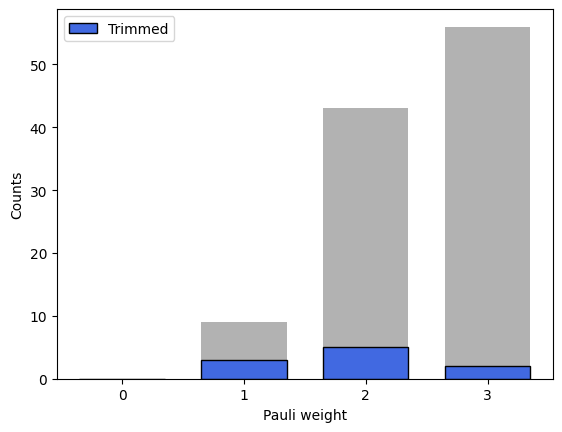

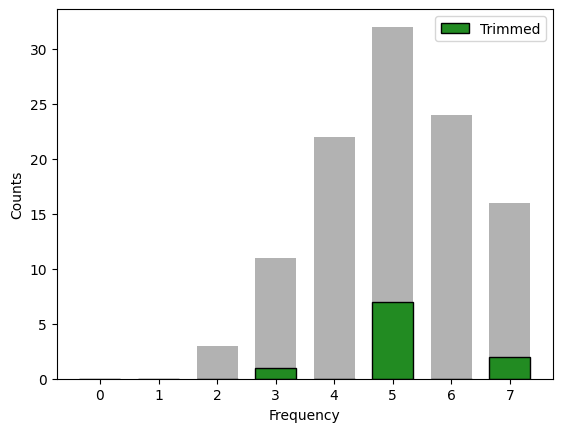

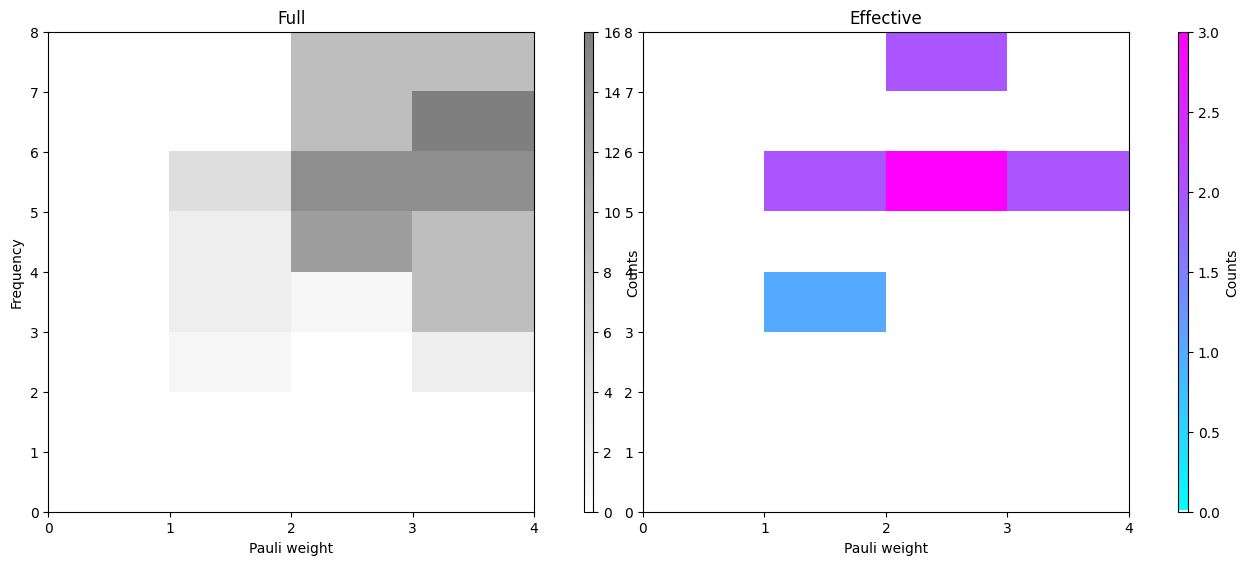

In [9]:
from pprop.plot.obs import plot_obsW, plot_obsF, plot_obs2D
plot_obsW(prop)
plot_obsF(prop)
plot_obs2D(prop)


> **Note:** Check out the other notebooks for additional examples and use cases.

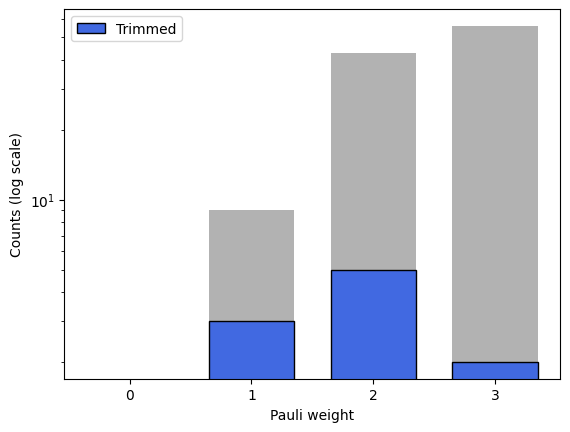

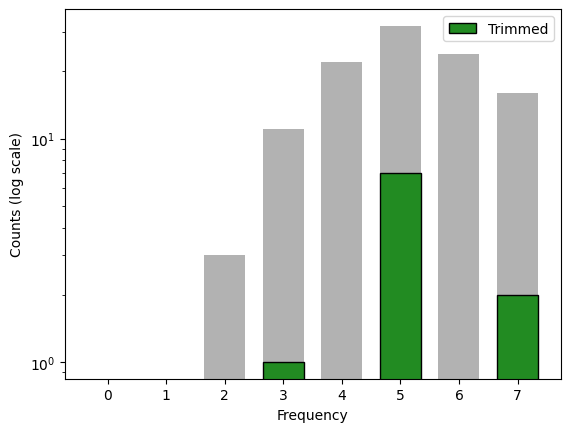

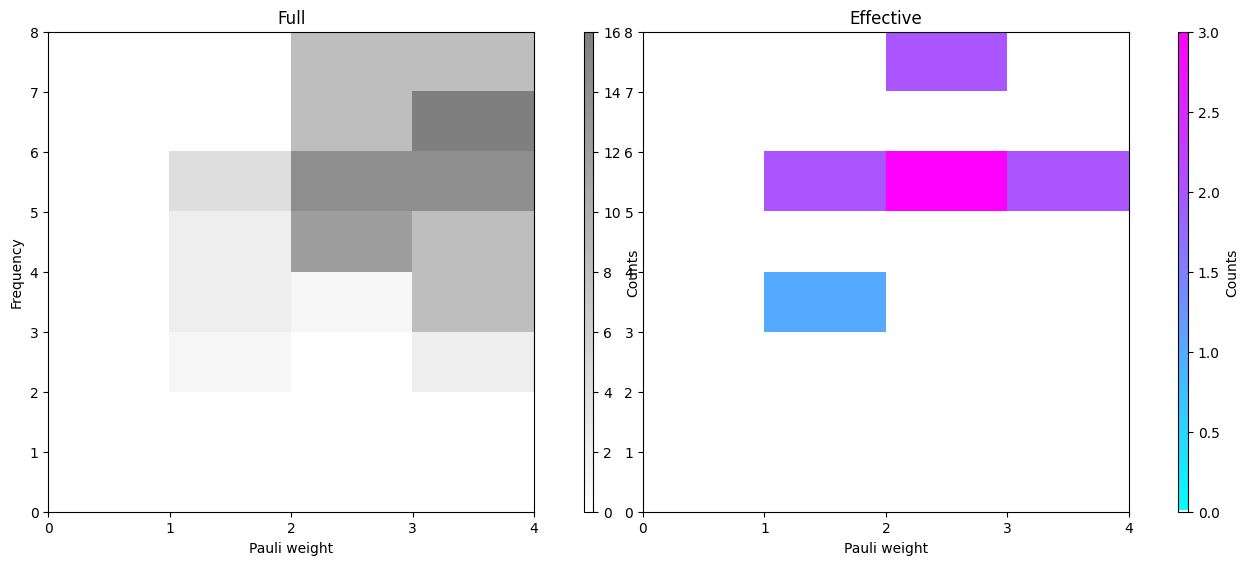

In [10]:
plot_obsW(prop, log=True)
plot_obsF(prop, log=True)
plot_obs2D(prop, log=False)